## Install (Colab only)
Skip this step when running locally.

In [1]:
#!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)

In [3]:
# ground truth system model
gt_model = psl.nonautonomous.VanDerPolControl()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = -5.
umax = 5.
xmin = -4.
xmax = 4.

## SINDy System Identification

First, we will construct the SINDy system identification problem to learn our ODE. For a more in depth example of using SINDy for system identification in Neuromancer, go [here](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/ODEs/Part_9_SINDy.ipynb).

In [4]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'r': trainX, 'xn': trainX[:, 0:1, :], 'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'r': devX, 'xn': devX[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testU = test_sim['U'][:length].reshape(1, nsim, nu)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'r': testX, 'xn': testX[:, 0:1, :], 'u': testU}

    return train_loader, dev_loader, test_data

In [5]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)

## Construct SINDy Model

Here we construct a SINDy model $\dot{x_k} = \theta(x_k, u_k)\xi_k$, which uses aims to fit the correct coefficient values $\xi_k$ to properly predict the change in $x_k$ given the state and the input. In the construction of our model, we add bounds on the states, which is based on prior knowledge we have about the two tank system.

In [6]:
theta_1 = library.PolynomialLibrary(nx, nu, 3)

theta_2_funs = [lambda X, u: torch.sqrt(X[:,0]), lambda X, u: torch.sqrt(X[:,1])]
theta_2_names = ["sqrt(x_0)", "sqrt(x_1)"]
theta_2 = library.FunctionLibrary(theta_2_funs, nx, nu, theta_2_names)

theta_3 = library.FourierLibrary(nx, nu, 1)

fx = sindy.SINDy(library.CombinedLibrary([theta_1]))

In [7]:
integrator = integrators.Euler(fx, h=ts)
integrator_node = Node(integrator, ['xn', 'u'], ['x'])
x_bound = Node(lambda x: torch.clamp(x, xmin, xmax), ['x'], ['xn'])
dynamics_model = System([integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")

## Define system identification loss function terms


In [8]:
# %% Constraints + losses:
x = variable("r")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0]))
loss_l1 = 0.0001*(l1 == 0)

## Construct System ID learning problem

In [9]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss, loss_l1]

# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [10]:
optimizer = torch.optim.AdamW(problem.parameters(),
                             lr=0.001)
# trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=1000,
    epochs=4000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [11]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 10.472247123718262
epoch: 1  train_loss: 10.313922882080078
epoch: 2  train_loss: 10.168306350708008
epoch: 3  train_loss: 10.027054786682129
epoch: 4  train_loss: 9.89194393157959
epoch: 5  train_loss: 9.774749755859375
epoch: 6  train_loss: 9.665377616882324
epoch: 7  train_loss: 9.5711030960083
epoch: 8  train_loss: 9.482450485229492
epoch: 9  train_loss: 9.40953254699707
epoch: 10  train_loss: 9.334014892578125
epoch: 11  train_loss: 9.26590633392334
epoch: 12  train_loss: 9.199912071228027
epoch: 13  train_loss: 9.137185096740723
epoch: 14  train_loss: 9.075157165527344
epoch: 15  train_loss: 9.021297454833984
epoch: 16  train_loss: 8.96985149383545
epoch: 17  train_loss: 8.927268028259277
epoch: 18  train_loss: 8.886199951171875
epoch: 19  train_loss: 8.848443984985352
epoch: 20  train_loss: 8.811330795288086
epoch: 21  train_loss: 8.777228355407715
epoch: 22  train_loss: 8.745000839233398
epoch: 23  train_loss: 8.711588859558105
epoch: 24  train_loss: 8.679

<All keys matched successfully>

## Model Evaluation

Here we print out our model to find the active terms. Additionally, we plot our model against the test data, so that we can see that the model can accurately predict the trajectory of our state variables. 

In [12]:
print(fx)

dx0/dt = -0.053*x0 + 0.970*x1 + 0.052*u0 + -0.024*x0^2*x1 + -0.020*x0*x1^2 + 0.012*x1^3 + -0.016*x1^2*u0 
dx1/dt = -0.018*1 + -0.595*x0 + -0.017*x1 + 0.558*u0 + -0.020*x0*x1 + 0.038*x1^2 + -0.014*x1*u0 + -0.515*x0^2*x1 + -0.465*x0*x1^2 + 0.104*x0*x1*u0 + 0.185*x1^3 + -0.062*x1^2*u0 + 0.014*x1*u0^2 



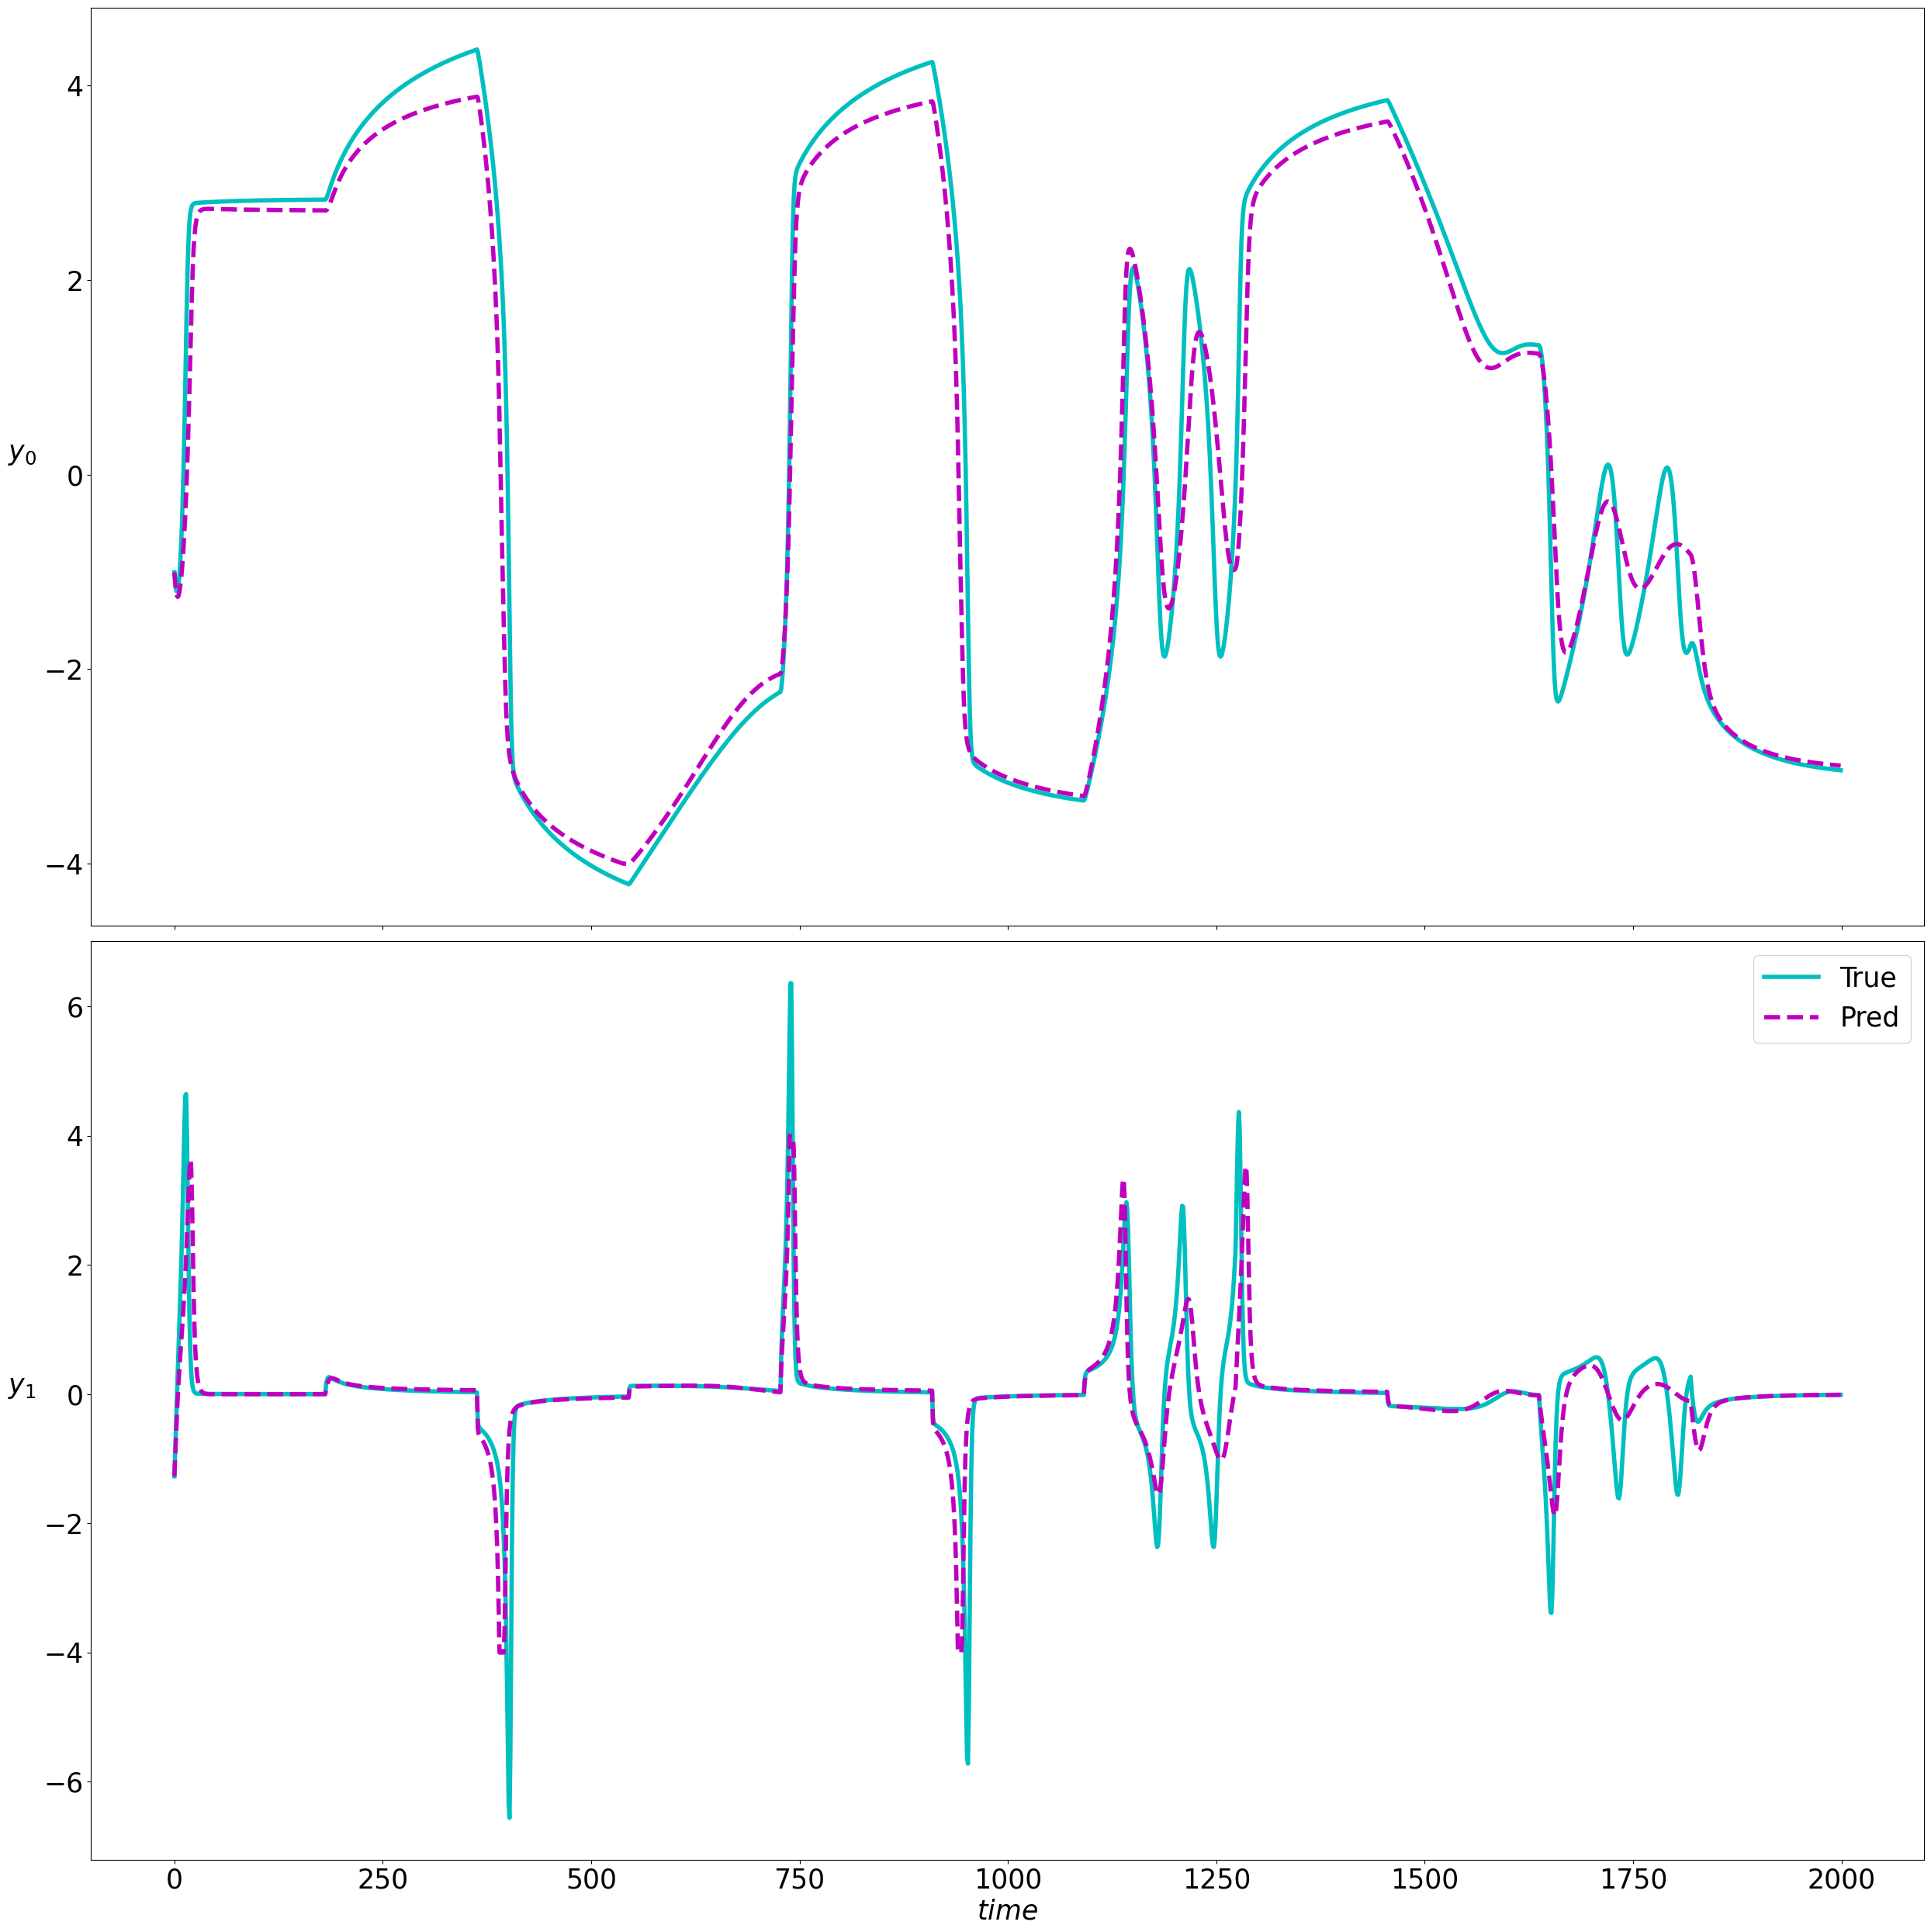

In [13]:
dynamics_model.nsteps = test_data['r'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['xn'][:, :-1, :]
true_traj = test_data['r']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

# Differentiable Predictive Control 

Next we show how to solve the corresponding parametric optimal control using the [DPC method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) implemented in Neuromancer.

**Schematics of the Differentiable Predictive Control method**:  
<img src="./figs/DPC_simple_method.png" width="600">  

**Neural control policy**:  
The objective of this tutorial is to learn neural control policy $u_k = \pi(x_k, R)$ to control the tank levels by modulating the pump and valve control actions $u_k = [p_k, v_k]$. The policy takes in the measurements of system states $x_k$ at thime $k$, prediciton of desired references $R = [r_k, ..., r_{k+N}]$ over pre-defined horizon $N$.

**Differentiable system model**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In this example, we compactly represent the system model by ODE equations  $\text{ODESolve}(\theta(x^i_k, u^i_k)\xi_k)$  describing the governing dynamics of the controlled system. 

**Differentiable predictive control problem formulation**:  
We learn the explicit neural control policy by solving the following parametric optimal control problem: 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m  \Big( \sum_{k=1}^{N-1} Q_x||x^i_k - r^i_k||_2^2  + Q_N||x^i_N - r^i_N||_2^2 \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(\theta(x^i_k, u^i_k)\xi_k) \\
&                     && u^i_k = \pi_{\theta}(x^i_k, R^i) \\
&                     && 0 \le x^i_k \le 1 \\
&                     && 0 \le u^i_k \le 1 \\
&                     && x^i_0 \sim \mathcal{P}_{x_0} \\
&                     && R^i \sim  \mathcal{P}_R
\end{align}
$$  
The objective function is to minimize the reference tracking error $||x^i_k - r^i_k||_2^2$ over pre-defined prediction horizon $N$ weighted by a scalar $Q_x$, including terminal penalty weighted by $Q_N$.  The parametric neural control policy is given by $\pi_{\theta}(x^i_k, R^i)$. The neural control policy is optimized over a problem parameters sampled from the distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, for state initial conditions, and references, respectively. The parameters $\theta$ are optimized with stochastic gradient descent.

## Training dataset generation

For a training dataset we randomly sample initial conditions of states and sequence of admissible reference trajectories over predefined prediction horizon from given distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, respectively.

In [14]:
def get_policy_data(nsteps, n_samples):
    # Training dataset generation
    train_data = DictDataset({'xn': torch.randn(n_samples, 1, nx),
                          'r': torch.zeros(n_samples, nsteps+1, nx)}, name='train')
    # Development dataset generation
    dev_data = DictDataset({'xn': torch.randn(n_samples, 1, nx),
                        'r': torch.zeros(n_samples, nsteps+1, nx)}, name='dev')
    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn, shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn, shuffle=False)
    return train_loader, dev_loader

nsteps = 50  # prediction horizon
n_samples = 2000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

## System model and Control policy in Neuromancer

Here we construct a closed-loop system as differentiable computational graph by coinnecting the system dynamics model  $x_{k+1} = \text{ODESolve}(\theta(x_k, u_k)\xi_k)$ with neural control policy $u_k = \pi_{\theta}(x_k, R)$. Hence we obtain a trainable system architecture: 
$x_{k+1} = \text{ODESolve}(\theta(x_k, \pi_{\theta}(x_k, R))\xi_k)$. In this example our system dynamics model is our learned SINDy model.

In [15]:
# symbolic system model
model = Node(integrator, ['xn', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model, x_bound], nsteps=nsteps)
# cl_system.show()

## Differentiable Predictive Control objectives and constraints

Here we take advantage of Neuromancer's high level symbolic language to define objective and constraint terms of our optimal control problem.

In [16]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)

# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'

# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
]

## Differentiable optimal control problem 

Here we put things together to construct a differentibale optimal control problem.

In [17]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

## Solve the problem

We solve the problem using stochastic gradient descent over pre-defined training data of sampled parameters.

In [18]:
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 3.7712950706481934
epoch: 1  train_loss: 2.842357635498047
epoch: 2  train_loss: 2.3375682830810547
epoch: 3  train_loss: 2.0221035480499268
epoch: 4  train_loss: 1.795804738998413
epoch: 5  train_loss: 1.651139259338379
epoch: 6  train_loss: 1.5642338991165161
epoch: 7  train_loss: 1.5099111795425415
epoch: 8  train_loss: 1.4746041297912598
epoch: 9  train_loss: 1.4510915279388428
epoch: 10  train_loss: 1.4346668720245361
epoch: 11  train_loss: 1.4227327108383179
epoch: 12  train_loss: 1.413672924041748
epoch: 13  train_loss: 1.4065440893173218
epoch: 14  train_loss: 1.4007542133331299
epoch: 15  train_loss: 1.3959932327270508
epoch: 16  train_loss: 1.3920512199401855
epoch: 17  train_loss: 1.3887789249420166
epoch: 18  train_loss: 1.3860567808151245
epoch: 19  train_loss: 1.3837043046951294
epoch: 20  train_loss: 1.381657361984253
epoch: 21  train_loss: 1.37984299659729
epoch: 22  train_loss: 1.3782888650894165
epoch: 23  train_loss: 1.3768781423568726
epoch: 24

<All keys matched successfully>

# Evaluate best model on a system rollout 

Here we generate 5 different reference system states over 750 timesteps to see how our control policy will act to stabilize the system to these reference states.

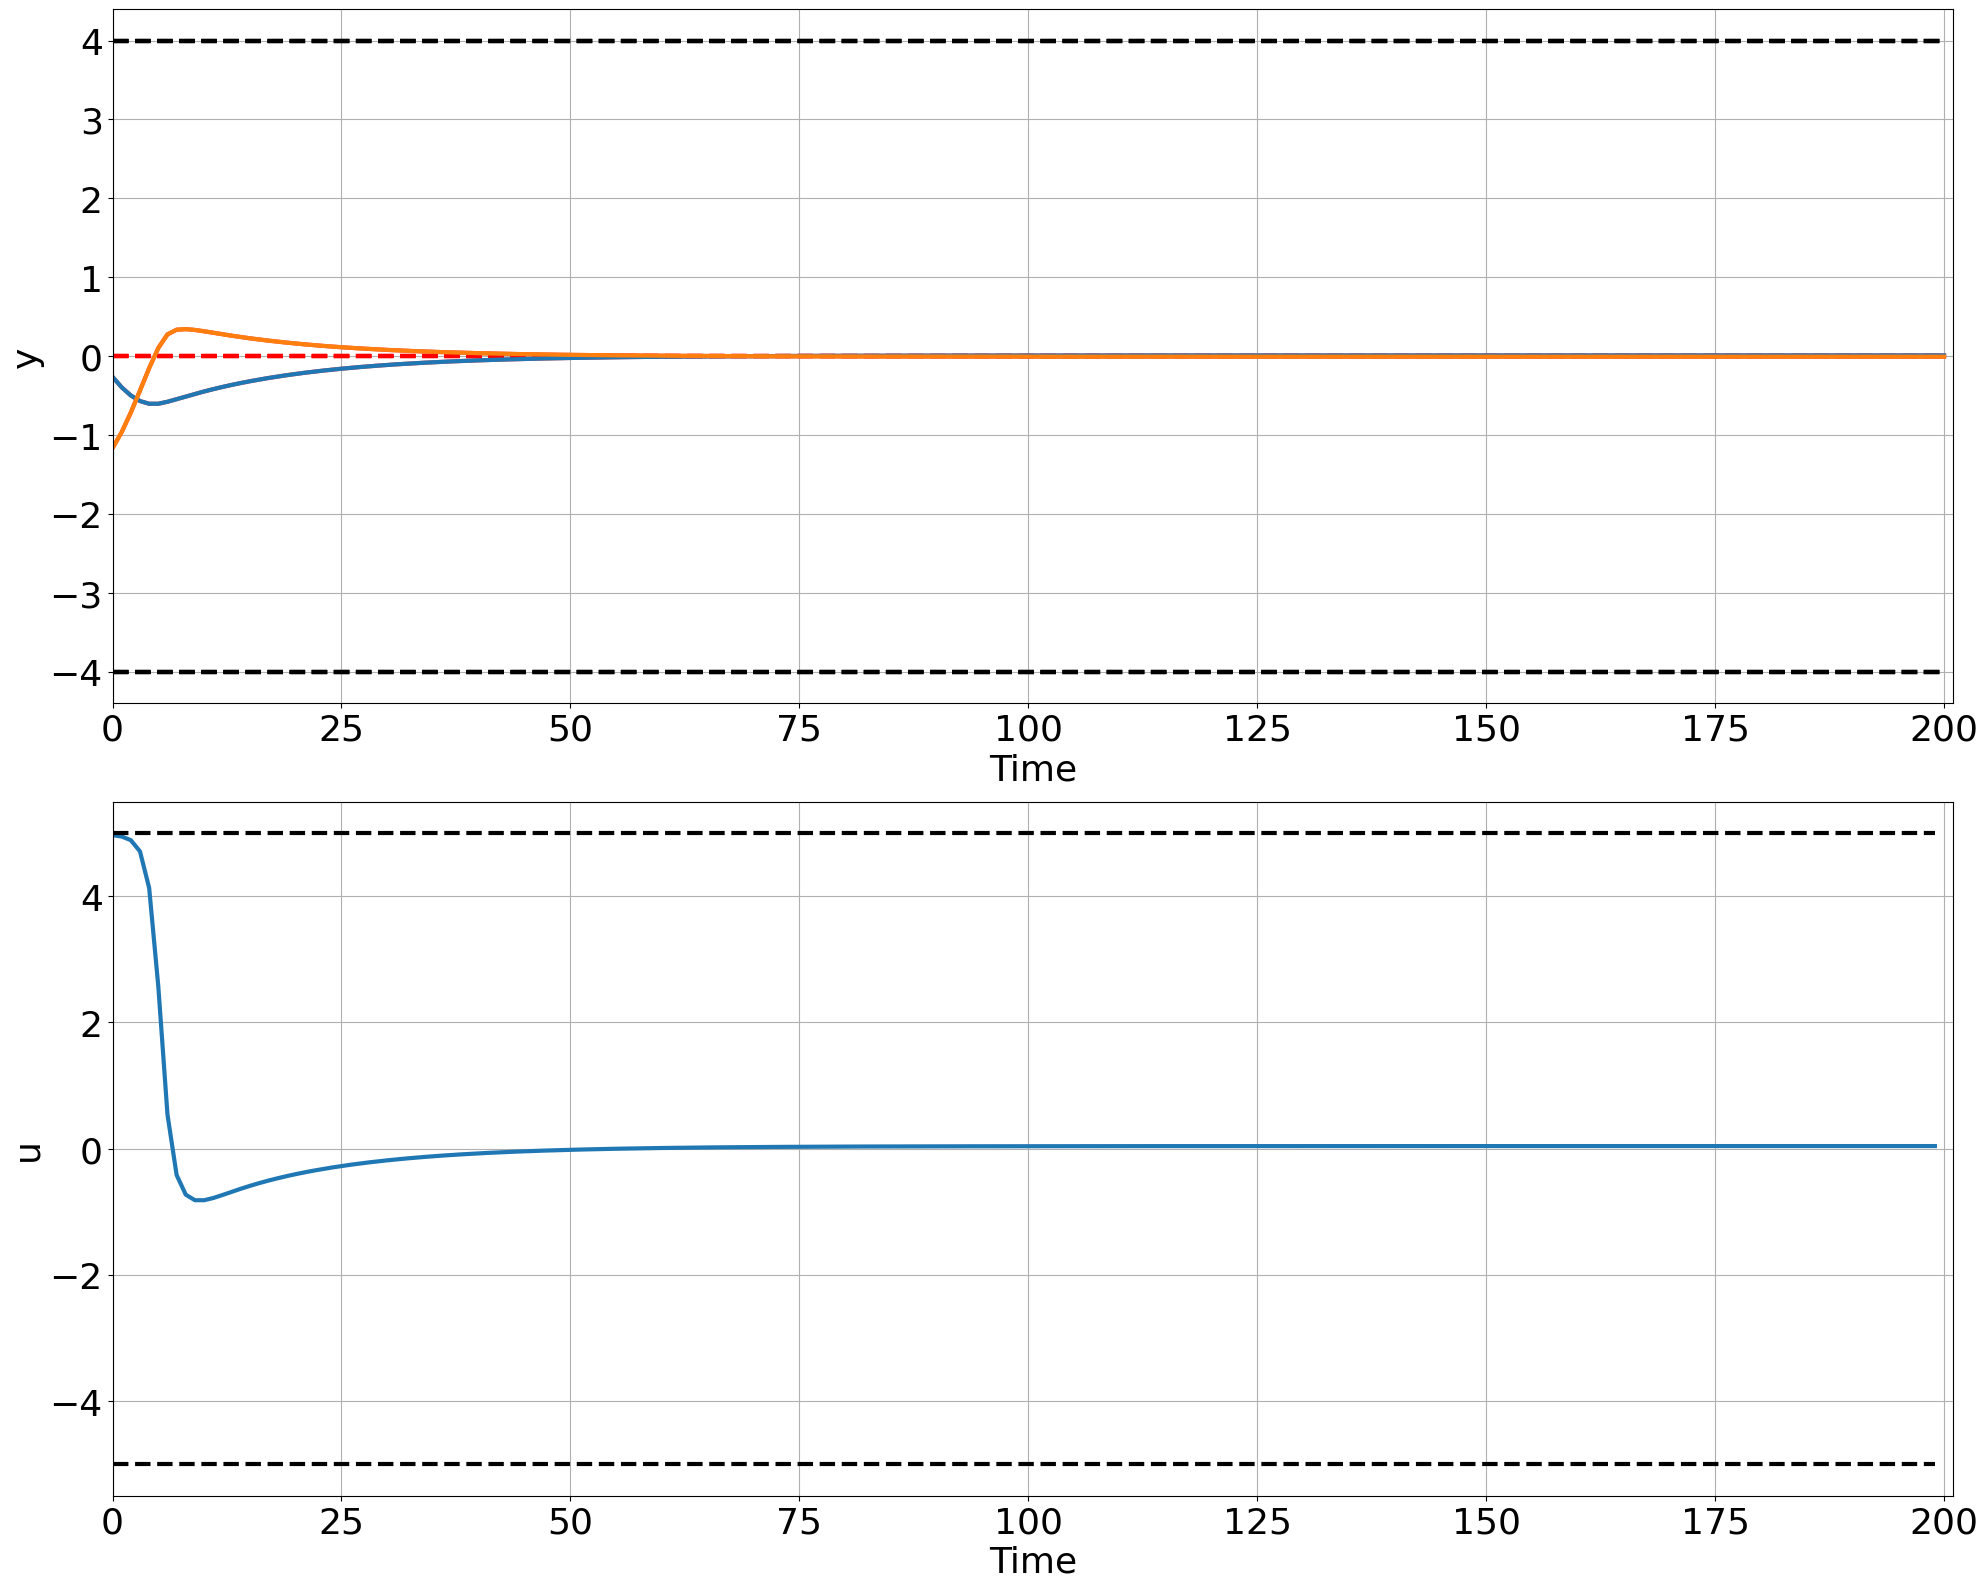

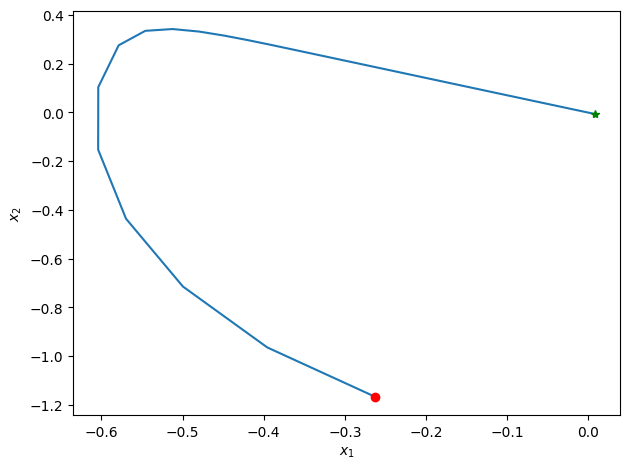

In [19]:
nsteps_test = 200
data = {'xn': torch.randn(1, 1, nx, dtype=torch.float32),
        'r': torch.zeros(1, nsteps_test+1, nx, dtype=torch.float32)}
cl_system.nsteps = nsteps_test
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps_test, nu])
Umax = umax * np.ones([nsteps_test, nu])
Xmin = xmin * np.ones([nsteps_test+1, nx])
Xmax = xmax * np.ones([nsteps_test+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps_test + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps_test + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps_test, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)
# plot phase portrait
pltPhase(X=trajectories['xn'].detach().reshape(nsteps_test + 1, nx))

## Dictionary Policy

Additionally, we can learn a sparse dictionary policy using the SINDy object. So now our neural control policy $u_k = \pi_{\theta}(x_k, R)$ can be represented by a sparse dictionary regression model instead of a neural network. As such we have $u_k = \theta(x_k, R)\xi_k$, where $\theta$ is our library and $\xi_k$ is our learned coefficient. Remember, we have the constraint for control inputs: $0 \le u^i_k \le 1$. So, to add this constraint, we use the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) to ensure that all control inputs generated by our policy meet this constraint.

In [21]:
torch.manual_seed(2)
nsteps_init = 2
n_iter = 1
max_degree = 2
max_freq = 2
lambda_l = 1e-7
p = 1

nsteps = nsteps_init  # prediction horizon
n_samples = 2000    # number of sampled scenarios

theta_1 = library.PolynomialLibrary(nx, nref, max_degree=max_degree)
theta_2 = library.FourierLibrary(nx, nref, max_freq=max_freq)

policy_sindy = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]), n_out=nu)
policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'], name="policy")
u_bound = Node(lambda u: torch.clamp(u, umin, umax), ['u_unbound'], ['u'])

sindy_system = System([policy_node, u_bound, integrator_node, x_bound], nsteps=nsteps)

hyperparameters = [nsteps, p]
initial_values = [2, 2]
stopping_conditions = [lambda nsteps: nsteps >= 10, lambda p: p > 2]
update_rules = [lambda nsteps: nsteps * 2, lambda p: p + 1]

In [22]:
# variables
x = variable('xn')
ref = variable('r')
u = variable('u')
l2 = variable([x], lambda x: torch.norm(list(fx.parameters())[0], 2))
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0], 1))

loss_l2 = lambda_l*(l2 == 0)
loss_l1 = lambda_l*(l1 == 0)

# objectives
regulation_loss = 5.*((x == ref)^2)  # target posistion
state_lower_bound_penalty = 2.5*(x > xmin)
state_upper_bound_penalty = 2.5*(x < xmax)
terminal_lower_bound_penalty = 2.5*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 2.5*(x[:, [-1], :] < ref+0.01)

# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss, loss_l1]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
]

In [23]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

In [24]:
optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=250,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
)

## Model Training

Here, we draw on the idea of [cirriculum learning](https://en.wikipedia.org/wiki/Curriculum_learning) to gradually increase the number of rollout steps of our model. So, we start with by learning the sparse dictionary policy for how to control the system for the next two timesteps. As we progress through training, we increase the number of timesteps we learn for which we learn the policy. This progressive type of training allows us to learn the policy while gradually making the learning task more complex.

In [25]:
train_loader, dev_loader = get_policy_data(nsteps, n_samples)
trainer.train_data, trainer.dev_data = train_loader, dev_loader 

for hyper, stop, update, value in zip(hyperparameters, stopping_conditions, update_rules, initial_values):
    hyperparameter = hyper
    stopping_condition = stop
    update_rule = update

    
    while not stopping_condition(hyperparameter):
        print(f"Next Iteration: {hyperparameter}")
        trainer.problem = problem
        
        # Train control policy
        best_model = trainer.train()
        
        # load best trained model
        trainer.model.load_state_dict(best_model)

        hyperparameter = update_rule(hyperparameter)
        sindy_system.nsteps = nsteps
        trainer.badcount = 0

    hyperparameter = value

Next Iteration: 2
epoch: 0  train_loss: 5.332796096801758
epoch: 1  train_loss: 5.27187442779541
epoch: 2  train_loss: 5.1970930099487305
epoch: 3  train_loss: 5.123547554016113
epoch: 4  train_loss: 5.059992790222168
epoch: 5  train_loss: 5.004578113555908
epoch: 6  train_loss: 4.9566121101379395
epoch: 7  train_loss: 4.91635799407959
epoch: 8  train_loss: 4.882377624511719
epoch: 9  train_loss: 4.853278160095215
epoch: 10  train_loss: 4.828153610229492
epoch: 11  train_loss: 4.806282043457031
epoch: 12  train_loss: 4.787107944488525
epoch: 13  train_loss: 4.770196437835693
epoch: 14  train_loss: 4.755178451538086
epoch: 15  train_loss: 4.741828918457031
epoch: 16  train_loss: 4.729935169219971
epoch: 17  train_loss: 4.719319820404053
epoch: 18  train_loss: 4.709834575653076
epoch: 19  train_loss: 4.70133113861084
epoch: 20  train_loss: 4.6936936378479
epoch: 21  train_loss: 4.686849117279053
epoch: 22  train_loss: 4.680682182312012
epoch: 23  train_loss: 4.675008773803711
epoch: 24  

## Compare Dictionary Policy to Neural Policy
Again, we rollout both of our models to 5 desired reference states over 750 timestep to compare the two policies. As we can see, our dictionary policy does a slightly better job of controlling our system than the neural policy.

In [26]:
cl_system.nsteps = nsteps_test
sindy_system.nsteps = nsteps_test
# perform closed-loop simulation
trajectories_nn = cl_system(data)
trajectories_sindy = sindy_system(data)

In [27]:
nn_loss = torch.nn.functional.mse_loss(trajectories_nn['xn'], data['r'])
sindy_loss = torch.nn.functional.mse_loss(trajectories_sindy['xn'], data['r'])

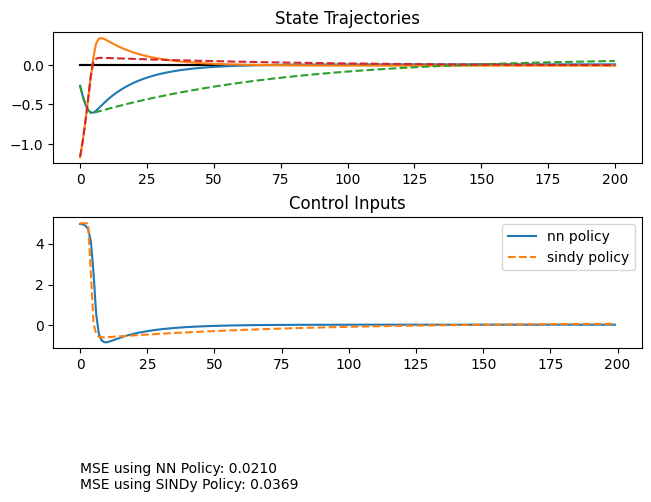

In [28]:
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
ax[0].set_title("State Trajectories")
ax[0].plot(data['r'].detach().numpy().reshape(nsteps_test+1, nref), '-', color="black", label="reference")
ax[0].plot(trajectories_nn['xn'].detach().numpy().reshape(nsteps_test+1, nx), label='nn policy')
ax[0].plot(trajectories_sindy['xn'].detach().numpy().reshape(nsteps_test+1, nx), '--', label='sindy policy')
ax[1].set_title("Control Inputs")
ax[1].plot(trajectories_nn['u'].detach().numpy().reshape(nsteps_test, nu), label='nn policy')
ax[1].plot(trajectories_sindy['u'].detach().numpy().reshape(nsteps_test, nu), '--', label='sindy policy')
ax[1].text(0, -8, f"MSE using NN Policy: {nn_loss.item():.4f}\nMSE using SINDy Policy: {sindy_loss.item():.4f}")
plt.legend()
#plt.savefig('van_der_pol.png', bbox_inches='tight')

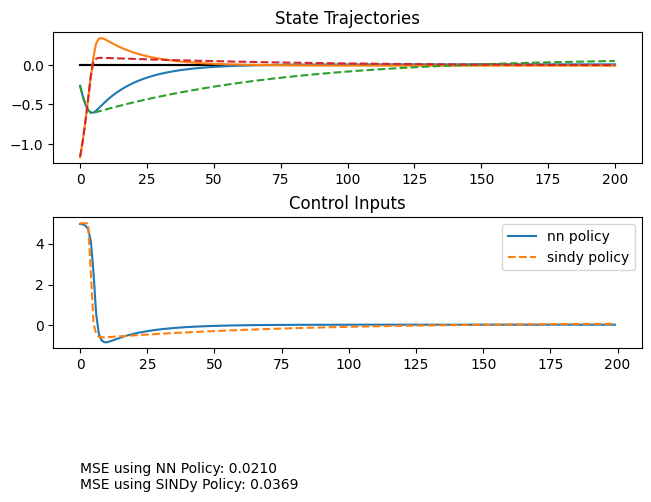

In [29]:
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
ax[0].set_title("State Trajectories")
ax[0].plot(data['r'].detach().numpy().reshape(nsteps_test+1, nref), '-', color="black", label="reference")
ax[0].plot(trajectories_nn['xn'].detach().numpy().reshape(nsteps_test+1, nx), label='nn policy')
ax[0].plot(trajectories_sindy['xn'].detach().numpy().reshape(nsteps_test+1, nx), '--', label='sindy policy')
ax[1].set_title("Control Inputs")
ax[1].plot(trajectories_nn['u'].detach().numpy().reshape(nsteps_test, nu), label='nn policy')
ax[1].plot(trajectories_sindy['u'].detach().numpy().reshape(nsteps_test, nu), '--', label='sindy policy')
ax[1].text(0, -8, f"MSE using NN Policy: {nn_loss.item():.4f}\nMSE using SINDy Policy: {sindy_loss.item():.4f}")
plt.legend()
#plt.savefig('van_der_pol.png', bbox_inches='tight')

In [30]:
print(policy_sindy)

dx0/dt = 0.101*1 + -0.662*x0 + -1.454*x1 + 0.364*u0 + 0.548*u1 + 0.068*x0^2 + -0.257*x0*x1 + 0.074*x0*u0 + 0.472*x0*u1 + 0.174*x1^2 + 0.434*x1*u0 + 0.409*x1*u1 + 0.300*u0^2 + 0.698*u0*u1 + 0.410*u1^2 + -0.585*sin(1*x0) + 0.059*sin(2*x0) + -3.556*sin(1*x1) + -4.444*sin(2*x1) + 0.753*sin(1*u0) + 0.358*sin(1*u1) + 0.354*sin(2*u1) + 0.318*cos(1*x0) + 0.121*cos(2*x0) + 0.232*cos(1*x1) + 0.272*cos(2*x1) + -0.202*cos(1*u0) + -0.205*cos(2*u0) + -0.174*cos(1*u1) + -0.336*cos(2*u1) 

